In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcols
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm
import warnings
import dask.array as da
import cmocean
mplRC.paperRC2()
from dask.distributed import Client, LocalCluster

warnings.filterwarnings(action='ignore',message='Mean of empty slice',category=RuntimeWarning)
warnings.filterwarnings(action='ignore',message='invalid value encountered in scalar divide',
                        category=RuntimeWarning)

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
varLabels={'tos':'SST (°C)','hplusos':'Surface\nH$^+$ (μM)','omega_arag_0':'Surface \n$\Omega _a$',
           'o2_mean_100_600': '100-600m Mean\nO$_2$ (mol m$^{-3}$)','intpp':'Integrated PP\n (mol m$^{-2}$s$^{-1}$)',
          'spco2':'Surface\npCO$_2$ (μatm)'}

# plot AME versus annual percentile for each 3 scenarios (hist, 126, 370)

In [3]:
ivar='tos'
iscen='ESM4_ssp370_D1'
freq='daily'
qq=.95
scen0='ESM4_historical_D1'
yrspan0=ex.dictScenDates[scen0]
chdef0={'time':-1,'lat':90,'lon':90}
window=100
sf=xr.open_dataset(ex.fNameStatsFile(scen0,yrspan0,freq,ivar)) # open here in case closed by closeall() below
seg=ex.scenData(ivar,freq,iscen,chdef0)
seg.setrefstats(sf,scen0,yrspan0)
seg.setquant(qq)
seg.setAME(ex.openAME(iscen,ivar,seg.exdir))
#seg.exA_all()

2025-06-20 20:26:33.013920
2025-06-20 20:26:33.216813
tos degC


In [4]:
thresh=seg.hstats['qt'].sel(quantile=seg.q).data #values
seg.threshA=thresh

In [5]:
rt=seg.yrspan[-1]-seg.yrspan[0]+1
seg.threshD=seg.hstats['seas'].values+seg.hstats['qt_ds'].sel(quantile=seg.q).values

In [6]:
rclim=seg.rollAME(100)
seg.threshE100=rclim[seg.ivar].data
thresh=seg.threshE100.repeat(365,axis=0) 

In [7]:
seg.rollSeas100()

In [8]:
seg.threshG100=da.rechunk(da.tile(seg.threshD,(rt,)+tuple(np.ones(len(seg.chksz)-1,dtype=int))),seg.chksz)+seg.delta_rollSeas100 # corrected to tile!

In [9]:
np.shape(seg.threshG100)

(14600, 180, 360)

In [10]:
np.shape(seg.dat)

(14600, 180, 360)

In [11]:
ivar2='omega_arag_0'
sf2=xr.open_dataset(ex.fNameStatsFile(scen0,yrspan0,freq,ivar2)) # open here in case closed by closeall() below
seg2=ex.scenData(ivar2,freq,iscen,chdef0)
seg2.setrefstats(sf2,scen0,yrspan0)
seg2.setquant(qq)
seg2.setAME(ex.openAME(iscen,ivar2,seg2.exdir))
#seg.exA_all()

z_l meters
omega_arag_0 


In [12]:
seg2.q

0.05

In [13]:
thresh=seg2.hstats['qt'].sel(quantile=seg2.q).data #values
seg2.threshA=thresh
rt=seg2.yrspan[-1]-seg2.yrspan[0]+1
seg2.threshD=seg2.hstats['seas'].values+seg2.hstats['qt_ds'].sel(quantile=seg2.q).values
rclim=seg2.rollAME(100)
seg2.threshE100=rclim[seg2.ivar].data
thresh=seg2.threshE100.repeat(365,axis=0) 
seg2.rollSeas100()
seg2.threshG100=da.rechunk(da.tile(seg2.threshD,(rt,)+tuple(np.ones(len(seg2.chksz)-1,dtype=int))),seg2.chksz)+seg2.delta_rollSeas100 # corrected to tile!

In [14]:
seg3=ex.scenData(ivar2,freq,scen0,chdef0)

z_l meters
omega_arag_0 


In [16]:
seg.tdt[:5*365]

array([datetime.datetime(2061, 1, 1, 12, 0),
       datetime.datetime(2061, 1, 2, 12, 0),
       datetime.datetime(2061, 1, 3, 12, 0), ...,
       datetime.datetime(2065, 12, 29, 12, 0),
       datetime.datetime(2065, 12, 30, 12, 0),
       datetime.datetime(2065, 12, 31, 12, 0)], dtype=object)

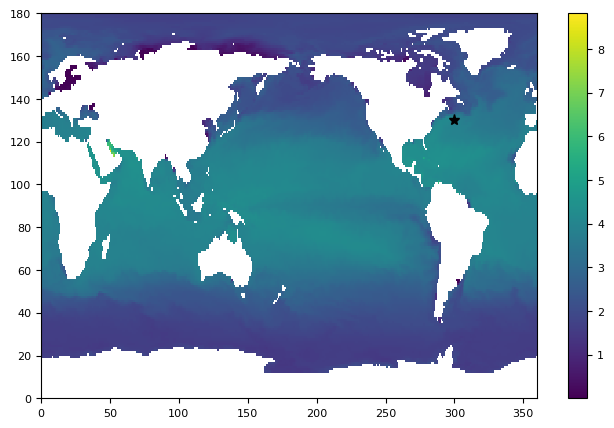

In [17]:
plt.pcolormesh(seg3.dat[180,:,:])
plt.plot(300,130,'k*')
plt.colorbar()

In [18]:
seg2.threshA[130,300]

2.9609859228134154

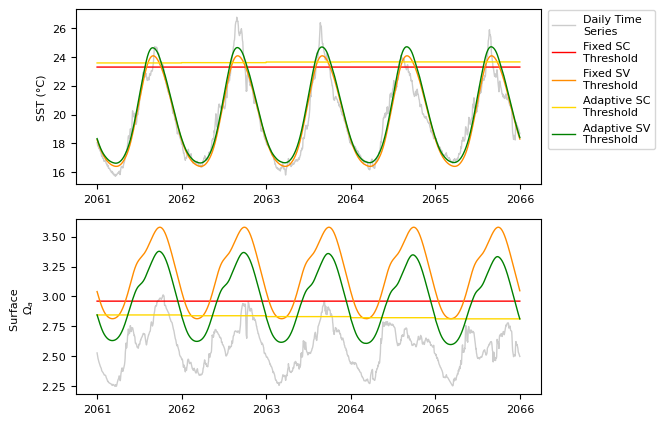

In [19]:
fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].plot(seg.tdt[:5*365],seg.dat[:5*365,130,300],'k-',alpha=.2,label='Daily Time\nSeries')
ax[0].plot(seg.tdt[:5*365],np.ones((365*5,))*seg.threshA[130,300],'r-',label='Fixed SC\nThreshold')
ax[0].plot(seg.tdt[:5*365],np.tile(seg.threshD[:,130,300],(5,)),color='darkorange',label='Fixed SV\nThreshold')
ax[0].plot(seg.tdt[:5*365],np.repeat(seg.threshE100[:5,130,300],365),color='gold',label='Adaptive SC\nThreshold')
ax[0].plot(seg.tdt[:5*365],seg.threshG100[:5*365,130,300],color='green',label='Adaptive SV\nThreshold')
ax[0].set_ylabel(varLabels[ivar])

ax[1].plot(seg2.tdt[:5*365],seg2.dat[:5*365,130,300],'k-',alpha=.2)
ax[1].plot(seg2.tdt[:5*365],np.ones((365*5,))*seg2.threshA[130,300],'r-')
ax[1].plot(seg2.tdt[:5*365],np.tile(seg2.threshD[:,130,300],(5,)),color='darkorange')
ax[1].plot(seg2.tdt[:5*365],np.repeat(seg2.threshE100[:5,130,300],365),color='gold')
ax[1].plot(seg2.tdt[:5*365],seg2.threshG100[:5*365,130,300],color='green')
ax[1].set_ylabel(varLabels[ivar2])
fig.legend(loc='upper right',bbox_to_anchor=[1.1,.89])
fig.savefig('thresholds.png',bbox_inches='tight')